# Image Classification Model Development

In [1]:
import pandas as pd 
from glob import glob
from sklearn.linear_model import LogisticRegression, Perceptron
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
columns = [f'pixel_{i}' for i in range(1296)]
columns.append('label')
df = pd.DataFrame(columns=columns)

car_folders = glob('/home/anuraaga/Documents/Projects/Project-PredthePrice/train_image/test_image/*')
car_folders

['/home/anuraaga/Documents/Projects/Project-PredthePrice/train_image/test_image/SUV',
 '/home/anuraaga/Documents/Projects/Project-PredthePrice/train_image/test_image/Hatchback',
 '/home/anuraaga/Documents/Projects/Project-PredthePrice/train_image/test_image/Seden',
 '/home/anuraaga/Documents/Projects/Project-PredthePrice/train_image/test_image/Pickup']

In [3]:
for folder in car_folders:
    car_images = glob(folder+'/*.jpg')
    for img in car_images:
        image = Image\
            .open(img)\
            .convert("L")\
            .resize((36,36), Image.ADAPTIVE)
        pixel_values = np.array(image).reshape(-1)
        normalized_pixel_values = pixel_values / 255
        row_data = np.concatenate([normalized_pixel_values, [folder.split('/')[-1]]])
        ndf = pd.DataFrame([row_data], columns=columns)
        df = pd.concat([df, ndf], ignore_index=True)   

In [11]:
for c in columns[:-1]:
    df[c] = df[c].astype('float64')
df['label'] = df['label'].astype(str)

In [12]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_1287,pixel_1288,pixel_1289,pixel_1290,pixel_1291,pixel_1292,pixel_1293,pixel_1294,pixel_1295,label
0,0.73,0.72,0.66,0.60,0.57,0.56,0.33,0.57,0.71,0.21,...,0.24,0.26,0.26,0.29,0.33,0.36,0.42,0.45,0.49,SUV
1,0.65,0.67,0.62,0.62,0.64,0.62,0.60,0.59,0.63,0.67,...,0.14,0.16,0.18,0.23,0.28,0.32,0.37,0.42,0.44,SUV
2,0.59,0.54,0.38,0.25,0.26,0.26,0.34,0.59,0.52,0.57,...,0.12,0.13,0.13,0.18,0.21,0.27,0.39,0.57,0.62,SUV
3,0.98,0.98,0.85,0.72,0.59,0.51,0.61,0.78,0.78,0.83,...,0.16,0.19,0.17,0.18,0.23,0.29,0.36,0.41,0.44,SUV
4,0.36,0.27,0.25,0.24,0.25,0.28,0.25,0.32,0.47,0.47,...,0.14,0.11,0.12,0.14,0.16,0.22,0.46,0.52,0.52,SUV


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4193 entries, 0 to 4192
Columns: 1297 entries, pixel_0 to label
dtypes: float64(1296), object(1)
memory usage: 41.5+ MB


In [25]:
df.to_parquet('new_image_dataset_36pixels.parquet', index=False, engine='fastparquet')

Run from here 

In [ ]:
df = pd.read_parquet('new_image_dataset_36pixels.parquet')

In [ ]:
df.head()

In [ ]:
models = pd.read_csv('newmodels_choice.csv') # used lazypredict to choice the preferred model 
models.head()

In [ ]:
df['label'].value_counts()

data is pretty imbalanced so we need oversampling

In [14]:
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
import seaborn as sns
sns.histplot(y)

In [15]:
from imblearn.over_sampling import RandomOverSampler
roversamp = RandomOverSampler()
newX, newY = roversamp.fit_resample(X, y)

In [16]:
newY.value_counts()

label
SUV          1689
Hatchback    1689
Seden        1689
Pickup       1689
Name: count, dtype: int64

In [ ]:
import seaborn as sns
sns.histplot(newY);

In [17]:
newY = newY.replace({'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3})
newY.value_counts()

label
3    1689
0    1689
2    1689
1    1689
Name: count, dtype: int64

In [18]:
nX_train, nX_test, ny_train, ny_test = train_test_split(newX, newY, test_size=0.3, random_state=42)

In [19]:
from sklearn.svm import SVC
clf = SVC(decision_function_shape='ovo', probability=True)
clf.fit(nX_train, ny_train)
ny_pred = clf.predict(nX_test)

In [24]:
print(f'Training Accuracy: {clf.score(nX_train, ny_train)*100:.2f}%')
print(f'Testing Accuracy: {clf.score(nX_test, ny_test)*100:.2f}%')

Training Accuracy: 99.98%
Testing Accuracy: 99.80%


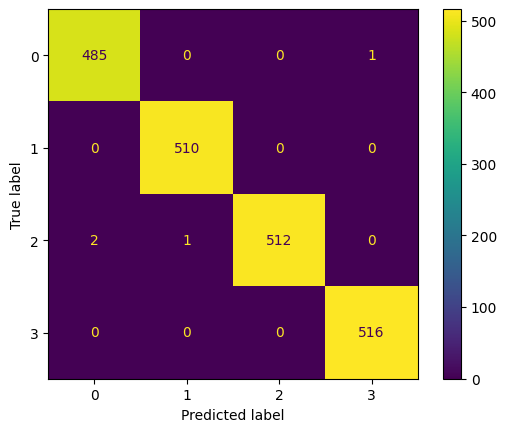

In [26]:
ConfusionMatrixDisplay(confusion_matrix(ny_test, ny_pred)).plot()

In [27]:
print(classification_report(ny_test, ny_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       486
           1       1.00      1.00      1.00       510
           2       1.00      0.99      1.00       515
           3       1.00      1.00      1.00       516

    accuracy                           1.00      2027
   macro avg       1.00      1.00      1.00      2027
weighted avg       1.00      1.00      1.00      2027



In [ ]:
# save model
import skops.io as sio 
sio.dump(clf, 'car_detection_model_svc_balanced.skops')

testing images

In [ ]:
imagepath = 'test_image/Hatchback/PHOTO_342.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
columns = [f'pixel_{i}' for i in range(1296)]

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
len(normalized_pixel_values)

In [ ]:
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'test_image/Pickup/PHOTO_342.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'test_image/Seden/PHOTO_548.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'test_image/SUV/PHOTO_123.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'checks/pickup.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'pickup2.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'checks/sedan.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'checks/sedan2.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'suv.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
imagepath = 'unknown.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
import skops.io as sio 
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
columns = [f'pixel_{i}' for i in range(1296)]
clf = sio.load('/home/anuraaga/Documents/Projects/Project-PredthePrice/docker/models/car_detection_model_svc.skops', trusted=True)

In [ ]:
imagepath = 'sedan3.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict_proba(ndf)

In [ ]:
imagepath = 'unknown2.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
clf.predict_proba(ndf)

In [ ]:
imagepath = 'unknown3.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
clf.predict_proba(ndf)

In [ ]:
imagepath = 'unknown4.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)

In [ ]:
clf.predict_proba(ndf)

In [ ]:
imagepath = 'unknown6.jpg'
image = Image.open(imagepath).convert("L")
resized_image = image.resize((36,36), Image.ADAPTIVE)
pixel_values = np.array(resized_image)
plt.imshow(pixel_values, cmap='gray')

In [ ]:
normalized_pixel_values = (pixel_values).reshape(-1) / 255
ndf = pd.DataFrame([normalized_pixel_values], columns=columns)

'Hatchback':0, 'Pickup':1, 'Seden':2, 'SUV':3

In [ ]:
clf.predict(ndf)